In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/Airlines'

/content/drive/My Drive/Airlines


# xgboost

## Lade benötigte Pakete und Daten

In [ ]:
import pandas as pd
import numpy as np
import plotly
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
import time

In [ ]:
train = pd.read_csv('data/train_set.csv')
train.shape

(102866, 23)

In [ ]:
train.head(5)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,0,1,42,1,0,1304,2,4,4,4,2,2,2,2,3,3,4,2,4,2,0,0.0
1,1,0,1,57,1,2,844,1,1,1,1,2,4,5,4,4,4,4,4,4,3,18,19.0
2,1,0,1,39,1,0,1716,4,2,2,2,4,4,4,4,1,4,3,1,3,4,1,0.0
3,0,1,1,42,1,2,1177,2,5,3,5,3,4,4,2,2,2,2,2,2,2,11,19.0
4,1,1,1,39,1,2,2017,3,3,3,3,4,4,5,5,5,5,5,4,5,5,7,29.0


In [ ]:
train.columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
      dtype='object')

Trenne Datensatz in Trainings- und Validierungsset. Verwende *random_state* für Reproduzierbarkeit.

In [ ]:
y = train['satisfaction']
X = train[['Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=32)

## Trainiere Modell

Erstelle zuerst Funktion für bequemeres Trainieren und trainiere danach ein Modell mit den *default*-Parametern:

In [ ]:
def run_model(model, X_train, y_train, X_val, y_val, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    roc_auc = roc_auc_score(y_val, y_pred)
    time_taken = round(time.time()-t0, 3)
    print("Time taken = {} seconds".format(time_taken))
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_val,y_pred,digits=5))
    plot_confusion_matrix(model, X_val, y_val,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, roc_auc

Time taken = 6.242 seconds
ROC_AUC = 0.9209738652459787
              precision    recall  f1-score   support

           0    0.91165   0.91363   0.91264      9205
           1    0.92995   0.92831   0.92913     11369

    accuracy                        0.92175     20574
   macro avg    0.92080   0.92097   0.92089     20574
weighted avg    0.92176   0.92175   0.92175     20574



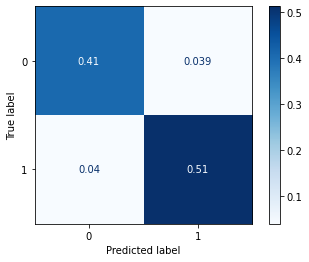

In [ ]:
params_xgb ={}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_val, y_val)

### Einfache Verbesserung

Trainiere ein Modell mit willkürlich gewählten Parametern und sieh, ob es zu einer Verbesserung führt:

Time taken = 6.037 seconds
ROC_AUC = 0.9225000237693348
              precision    recall  f1-score   support

           0    0.91283   0.91581   0.91432      9205
           1    0.93165   0.92919   0.93042     11369

    accuracy                        0.92320     20574
   macro avg    0.92224   0.92250   0.92237     20574
weighted avg    0.92323   0.92320   0.92322     20574



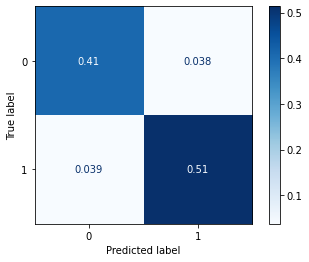

In [ ]:
params_xgb ={"eta": 0.02,
    "max_depth": 3,
    "objective": "binary:logistic",
    "subsample": 0.8,
    "min_child_weight": 0.1}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_val, y_val)

###Hyperparameter-Optimierung (Bayesian)

Installiere Paket für *Bayesian Optimization*. Anschließend setzen wir die Grenzen der Hyperparametersuche und führen anschließend die Optimierung mit Kreuzvalidierung durch. Die Ergebnisse werden in einer JSON-Datei geloggt.

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=f7a72b35b3d6c2380f1abde1db06cb74bdbf4bfa138ce5f714b3ad209b171c44
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

In [ ]:
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1500),
    'max_depth': (3,10),
    'subsample': (0.2, 1.0),
    'colsample': (0.2, 1.0),
    'gamma': (0, 5)}

In [ ]:
def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):
  
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = xgb.XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X, y, cv=4, scoring='roc_auc'))

In [ ]:
optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    verbose=2,
    random_state=1)

In [ ]:
# log progress
logger = JSONLogger(path="./xgb_logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(n_iter=20)

In [ ]:
print(optimizer.max)

{'target': 0.994358344843522, 'params': {'colsample': 0.5483448027415683, 'gamma': 0.24012379248469273, 'learning_rate': 0.051470735505974516, 'max_depth': 9.917587878572172, 'n_estimators': 649.4276142041917, 'subsample': 0.7509359630380461}}


### Trainiere neu mit optimierten Hyperparametern

Es werden verschiedene vielversprechende Parameterkonfigurationen aus der JSON verwendet, um Modelle zu trainieren und anschließend zu speichern.

In [ ]:
# Save model
import pickle

Time taken = 161.986 seconds
ROC_AUC = 0.9589497470393323
              precision    recall  f1-score   support

           0    0.94549   0.96285   0.95409      9205
           1    0.96946   0.95505   0.96220     11369

    accuracy                        0.95854     20574
   macro avg    0.95748   0.95895   0.95815     20574
weighted avg    0.95874   0.95854   0.95857     20574



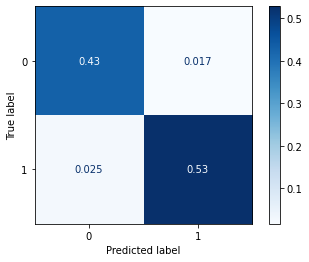

In [ ]:
params_xgb ={'learning_rate': 0.05147,
    'n_estimators': 649,
    'max_depth': 10,
    'subsample': 0.75,
    'colsample': 0.55,
    'gamma': 0.24}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_val, y_val)

filename = 'export/xgb_v1'
pickle.dump(model_xgb, open(filename, 'wb'))

Time taken = 173.641 seconds
ROC_AUC = 0.9595964736149155
              precision    recall  f1-score   support

           0    0.94662   0.96317   0.95482      9205
           1    0.96975   0.95602   0.96284     11369

    accuracy                        0.95922     20574
   macro avg    0.95818   0.95960   0.95883     20574
weighted avg    0.95940   0.95922   0.95925     20574



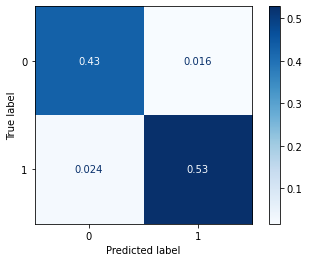

In [ ]:
params_xgb ={'learning_rate': 0.0422,
    'n_estimators': 668,
    'max_depth': 10,
    'subsample': 0.6578,
    'colsample': 0.677,
    'gamma': 0.0266}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_val, y_val)

filename = 'export/xgb_v2'
pickle.dump(model_xgb, open(filename, 'wb'))

Time taken = 134.371 seconds
ROC_AUC = 0.9593611452548118
              precision    recall  f1-score   support

           0    0.94727   0.96209   0.95462      9205
           1    0.96891   0.95664   0.96273     11369

    accuracy                        0.95907     20574
   macro avg    0.95809   0.95936   0.95868     20574
weighted avg    0.95923   0.95907   0.95910     20574



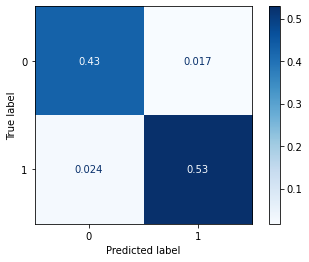

In [ ]:
params_xgb ={'learning_rate': 0.165,
    'n_estimators': 722,
    'max_depth': 10,
    'subsample': 0.981,
    'colsample': 0.843,
    'gamma': 0.486}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_val, y_val)

filename = 'export/xgb_v3'
pickle.dump(model_xgb, open(filename, 'wb'))

Bis hierhin war v2 bestes Resultat --> wir erhöhen die maximale Tiefe und Anzahl der Bäume:

Time taken = 278.929 seconds
ROC_AUC = 0.9595524943731176
              precision    recall  f1-score   support

           0    0.94651   0.96317   0.95477      9205
           1    0.96975   0.95593   0.96279     11369

    accuracy                        0.95917     20574
   macro avg    0.95813   0.95955   0.95878     20574
weighted avg    0.95935   0.95917   0.95920     20574



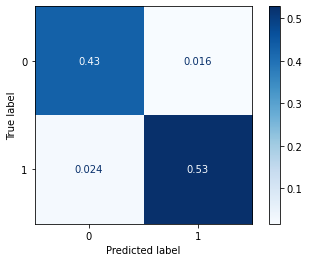

In [ ]:
params_xgb ={'learning_rate': 0.0422,
    'n_estimators': 750,
    'max_depth': 14,
    'subsample': 0.6578,
    'colsample': 0.677,
    'gamma': 0.0266}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_val, y_val)

filename = 'export/xgb_v4'
pickle.dump(model_xgb, open(filename, 'wb'))

## Modellevaluation

Lade Testset und berechne anschließend für all trainierten Modelle Genauigkeit und Fbeta(0,5)-Wert.

In [ ]:
test = pd.read_csv('data/test_set.csv')
test.shape

(25717, 23)

In [ ]:
y_test = test['satisfaction']
X_test = test[['Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]

In [ ]:
# Calculate Accuracy - v1
filename = 'export/xgb_v1'
model_xgb = pickle.load(open(filename, 'rb'))

result = model_xgb.score(X_test, y_test)
print(result)

0.9589765524750166


In [ ]:
# Calculate Fbeta - v1
y_pred = model_xgb.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print("F(0.5) = {}".format(fbeta))

F(0.5) = 0.9667186985349926


In [ ]:
# Calculate Accuracy - v2
filename = 'export/xgb_v2'
model_xgb = pickle.load(open(filename, 'rb'))

result = model_xgb.score(X_test, y_test)
print(result)

0.9588598981218649


In [ ]:
# Calculate Fbeta - v2
y_pred = model_xgb.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print("F(0.5) = {}".format(fbeta))

F(0.5) = 0.9675334932008443


In [ ]:
# Calculate Accuracy - v3
filename = 'export/xgb_v3'
model_xgb = pickle.load(open(filename, 'rb'))

result = model_xgb.score(X_test, y_test)
print(result)

0.9582766263561069


In [ ]:
# Calculate Fbeta - v3
y_pred = model_xgb.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print("F(0.5) = {}".format(fbeta))

F(0.5) = 0.9660351962426792


In [ ]:
# Calculate Accuracy - v4
filename = 'export/xgb_v4'
model_xgb = pickle.load(open(filename, 'rb'))

result = model_xgb.score(X_test, y_test)
print(result)

0.9583155111404907


In [ ]:
# Calculate Fbeta - v4
y_pred = model_xgb.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print("F(0.5) = {}".format(fbeta))

F(0.5) = 0.9673061723072502


## SHAP

Installiere/lade SHAP-Tool, lade bestes Modell und ggf. noch einmal die Testdaten:

In [ ]:
!pip install shap
import shap
import pickle

In [ ]:
filename = 'export/xgb_v2'
model_xgb = pickle.load(open(filename, 'rb'))

In [ ]:
test = pd.read_csv('data/test_set.csv')
y_test = test['satisfaction']
X_test = test[['Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]

Erstelle Tree Explainer:

In [ ]:
explainer = shap.TreeExplainer(model_xgb)

####Lokale Interpretationen

Hier werden einige Vorhersagen interpretierbar gemacht. Zu beachten ist, dass die Option 

```python
link='logit'
```
es ermöglicht die Variableneinflüsse als Veränderungen der Wahrscheinlichkeit zwischen 0 und 1 darstellen zu lassen. Per *default* werden normalerweise *log odds*-Werte dargestellt (s. https://github.com/slundberg/shap/issues/29).

In [ ]:
# use link=logit for binary: https://github.com/slundberg/shap/issues/29
choosen_instance = X_test.loc[[421]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, choosen_instance, link='logit')

In [ ]:
choosen_instance = X_test.loc[[1500]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, choosen_instance, link='logit')

In [ ]:
choosen_instance = X_test.loc[[3000]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, choosen_instance, link='logit')

In [ ]:
choosen_instance = X_test.loc[[18000]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, choosen_instance, link='logit')

####Globale Interpretationen

Da die Berechnung der SHAP-Werte für das gesamte Testset zu zeit- und rechenintensiv ist, wird ein Teildatensatz mit 2% der ursprünglichen Größe dem Testset entnommen. Verwende *random_state* für Reproduzierbarkeit.

In [ ]:
test = pd.read_csv('data/test_set.csv')
test.shape

(25717, 23)

In [ ]:
# Select random Subset of Testset to accelerate calculation
test_sub = test.sample(frac=0.02, random_state=32)
test_sub.shape

(514, 23)

In [ ]:
y_test_sub = test_sub['satisfaction']
X_test_sub = test_sub[['Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]

In [ ]:
shap_values_xgb_test = explainer.shap_values(X_test_sub)

In [ ]:
df_shap_xgb_test_1 = pd.DataFrame(shap_values_xgb_test, columns=X_test_sub.columns.values)

In [ ]:
df_shap_xgb_test_1

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,0.219933,1.711509,0.064012,1.074957,0.476191,-0.136862,0.533509,0.337529,0.449145,0.166883,0.029775,0.616202,0.708696,0.451033,0.421255,0.788262,0.616239,0.703708,0.400453,0.190827,-0.037774,-0.135033
1,-0.244453,0.401597,0.481831,0.575643,-0.116439,0.486051,0.537578,0.055808,0.135110,0.194231,0.017623,0.537892,-0.303636,0.406363,-0.026453,0.225822,0.799624,-0.526699,-0.060297,-0.103075,0.006684,0.225869
2,1.068251,0.685974,-0.178213,-0.845964,-0.267811,0.957047,0.823475,0.995113,-0.258278,0.513238,0.113909,1.431013,0.493786,0.609208,0.336590,0.639663,0.501526,0.330091,0.343717,0.028793,0.169664,-0.483651
3,0.132280,0.608772,0.265390,0.655578,0.055892,0.080187,5.144835,-0.320325,-0.005820,-0.122815,0.087319,0.125828,0.489154,1.119240,0.019023,0.094105,-0.268882,0.913488,-0.283359,0.442821,0.019258,0.246240
4,-0.575023,1.009846,0.246751,1.554252,0.512629,0.251494,0.834637,0.417883,0.167934,0.493027,-0.020346,2.559050,1.363703,0.578058,0.136373,0.362799,0.206660,0.140783,0.023524,0.091028,0.275413,-0.476722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,-0.256761,-3.006587,0.381334,0.686181,0.899878,-0.064694,-1.048097,0.364244,0.150264,0.152906,-0.021167,-1.777594,0.375278,-0.320392,-0.077008,-0.179504,0.180472,0.689735,0.256538,0.456029,-0.096537,0.042599
510,-0.275517,0.550040,0.341377,0.606190,0.044964,0.115230,-1.737387,-0.221728,0.115925,-0.539172,0.037667,-1.615881,-0.134913,-0.337617,-0.500540,0.030712,-0.545520,-0.051659,-0.441136,-0.081764,0.087616,0.143248
511,-0.170880,-1.068138,0.130779,0.486060,-0.149887,0.040448,5.882844,-0.141729,0.202639,0.072289,0.080027,1.943905,-0.006632,0.054460,0.259501,-0.003407,-0.374120,0.302348,0.425438,-0.001000,0.024576,0.090128
512,0.244010,1.101635,-0.088982,0.648683,0.322065,-0.027591,1.008767,-0.027267,0.233825,0.729410,0.046267,3.125023,1.618992,-0.094621,-0.194551,-0.143191,-0.057900,0.138560,-0.078040,0.228055,0.034178,0.198807


Hier werden globale Interpretationen mehrerer Vorhersagen ermöglicht. Zuerst wird für jede Variable ein *Dependence plot* gezeichnet, bei denen auf der x-Achse der Wert der Variable, auf der y-Achse der SHAP-Wert und durch die Färbung die am stärksten interagierende andere Variable illustriert wird. 

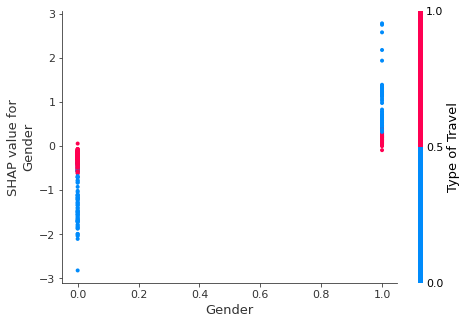

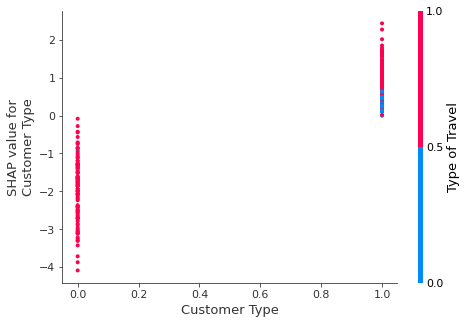

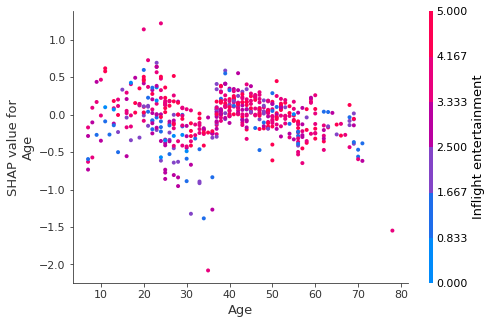

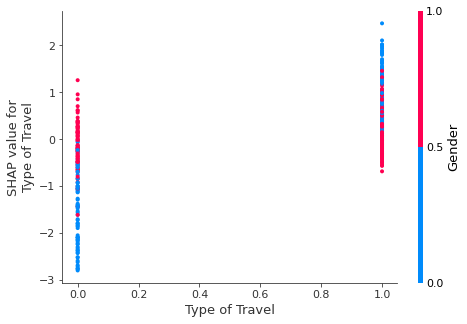

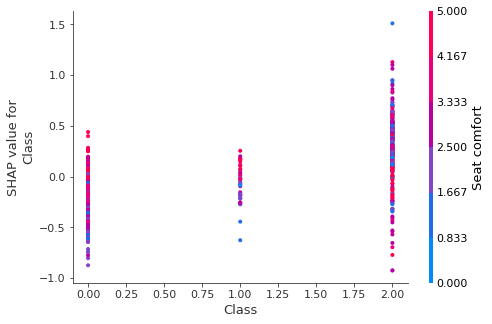

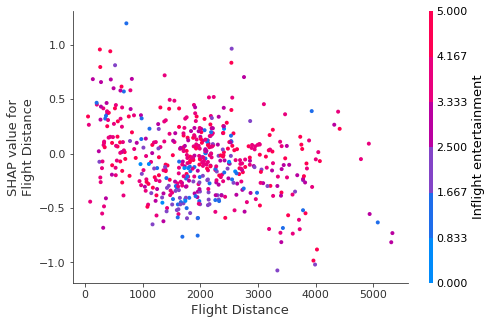

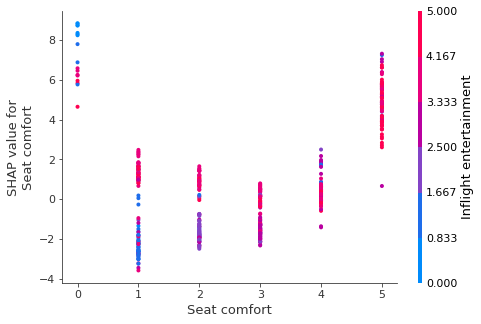

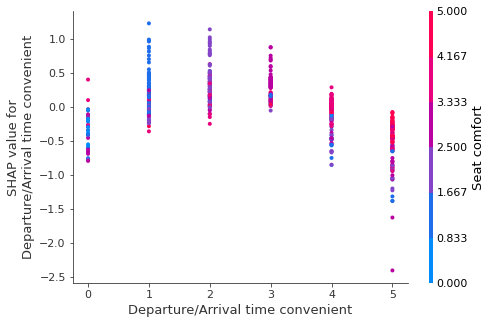

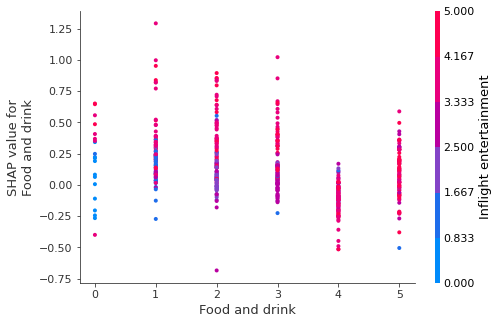

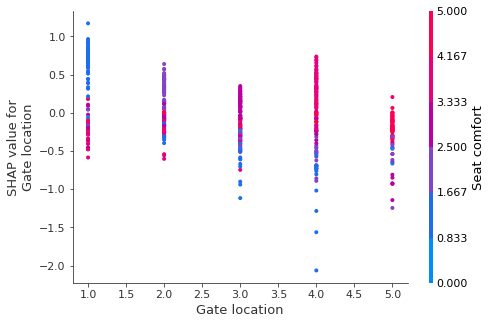

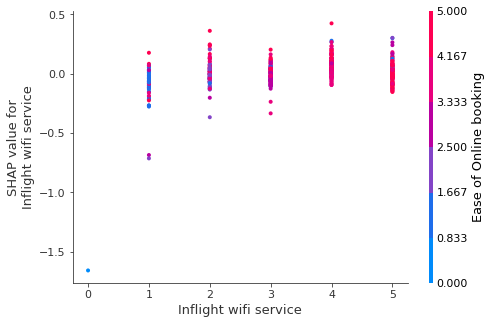

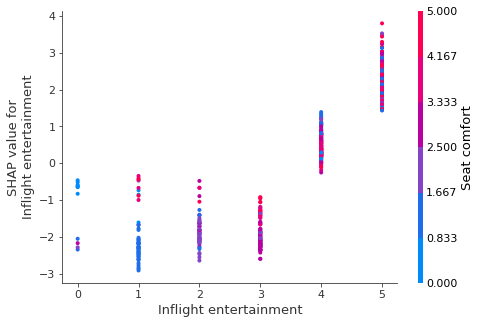

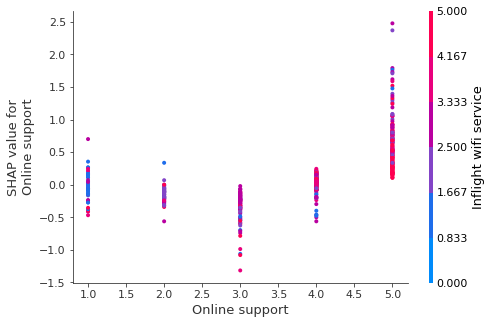

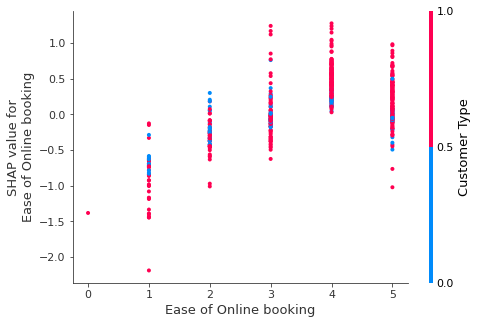

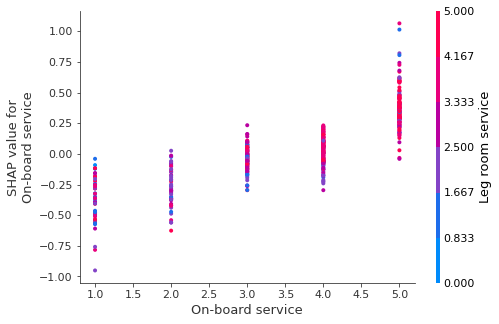

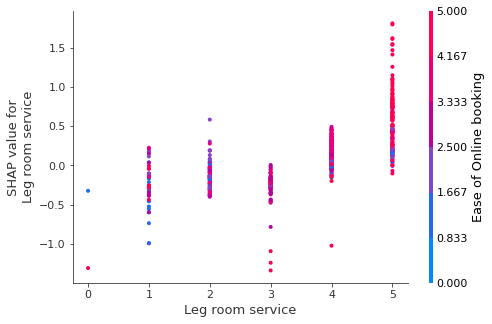

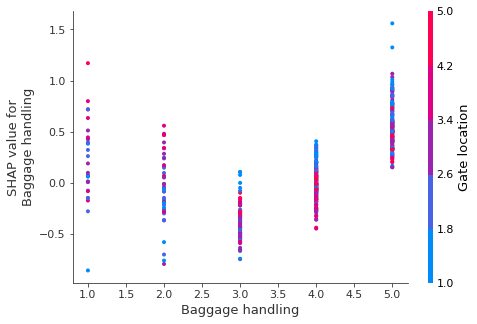

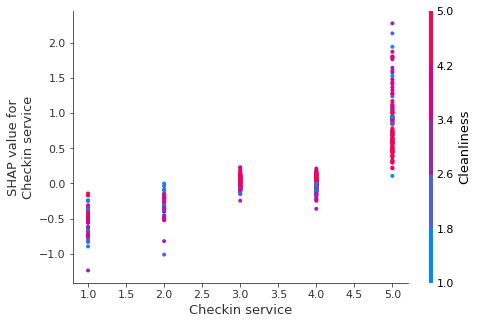

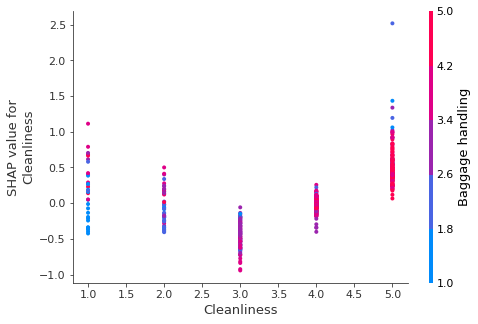

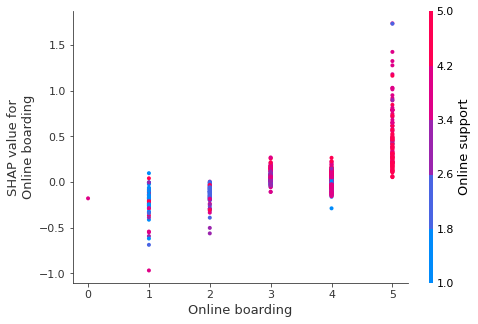

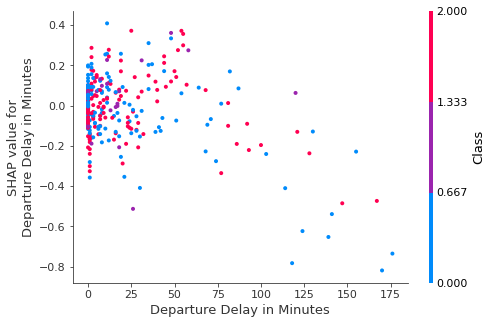

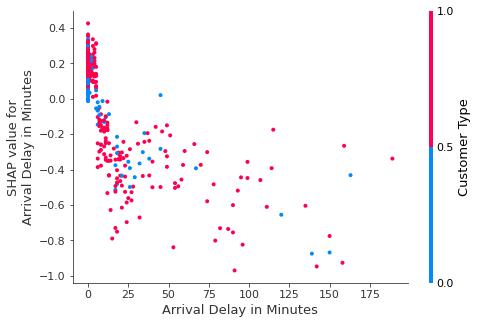

In [ ]:
for name in X_test_sub.columns:
    shap.dependence_plot(name, shap_values_xgb_test, X_test_sub)

In den beiden *Summary plots* sind die Variablen von oben nach unten absteigend nach ihrem durschnittlichen Einfluss auf die Vorhersage geordnet. Im ersten Schaubild ist zudem die Verteilung der SHAP-Werte pro Variable in Abhängigkeit von den Variablenwerten der Fluggäste ablesbar.

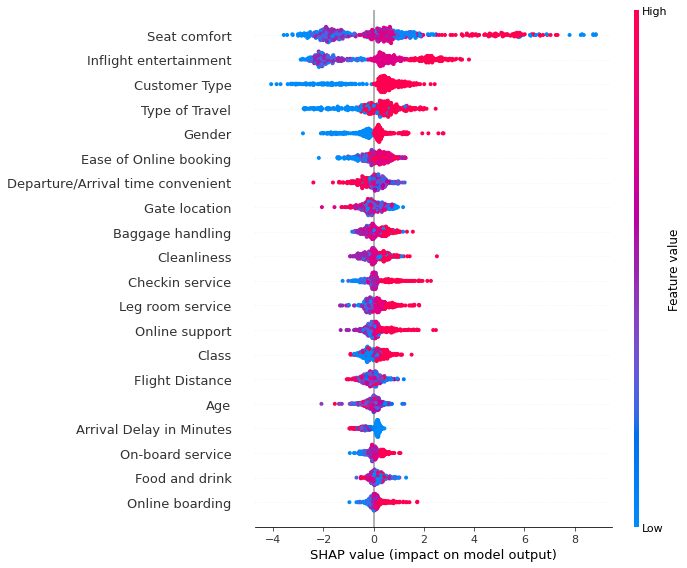

In [ ]:
shap.summary_plot(shap_values_xgb_test, X_test_sub)

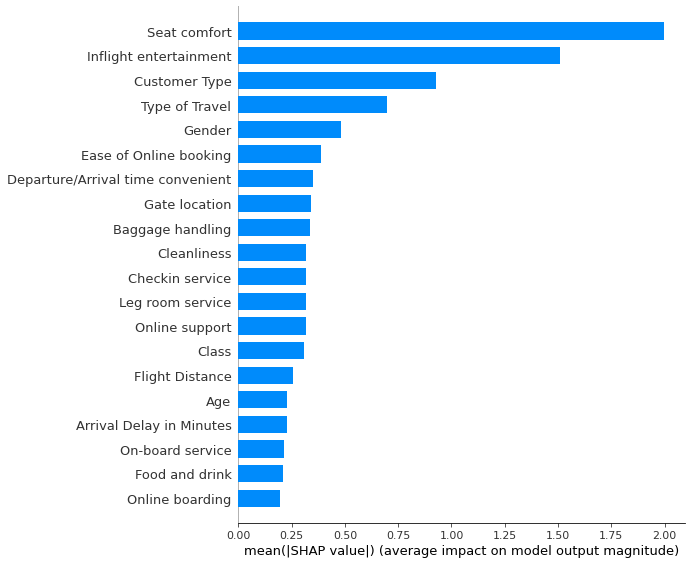

In [ ]:
shap.initjs()
shap.summary_plot(shap_values_xgb_test, X_test_sub, plot_type="bar")

Die letzte Grafik zeigt die Einflüsse der Variablen auf die Vorhersagen für alle 513 Einträge des Teildatensatzes. Dabei sind die Beobachtungen nach ihrer Ähnlichkeit geordnet.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_xgb_test, X_test_sub, link='logit')